In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy  as np
import tables as tb
import random as rd
import h5py

from __future__           import print_function
from keras.models         import load_model
from mpl_toolkits.mplot3d import Axes3D

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)
/home/jmbenlloch/.local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
print('---Loading Data...')
dnn_dat = tb.open_file('dnn_data/prepared_events_200k.h', 'r'); print(dnn_dat)
x_tv    = np.array(dnn_dat.root.x)
x_tv   /= np.max(x_tv)
x_tv    = np.reshape(x_tv,(len(x_tv),1,30,20,20))
y_tv    = np.array(dnn_dat.root.y)
nslices = x_tv.shape[1]
dnn_dat.close()
print('---Load Complete.')

---Loading Data...
dnn_data/prepared_events_200k.h (File) ''
Last modif.: 'Wed Oct 12 13:23:57 2016'
Object Tree: 
/ (RootGroup) ''
/x (EArray(397901, 30, 400), blosc(9)) ''
/y (EArray(397901, 1), blosc(9)) ''

---Load Complete.


In [3]:
# Specify at which index began validation set
Ntrain=360000
print('---Loading Model...')
model = load_model('models/conv3d_200k.h')
print('---Computing predictions...')
y_pred = model.predict(x_tv[Ntrain:])
y_     = y_tv[Ntrain:]
xv     = x_tv[Ntrain:]
print('Accuracy: ' + str(((np.array(np.round(y_pred),dtype=np.int))==y_).sum()/float(len(y_))))

---Loading Model...
---Computing predictions...
Accuracy: 0.983298593705


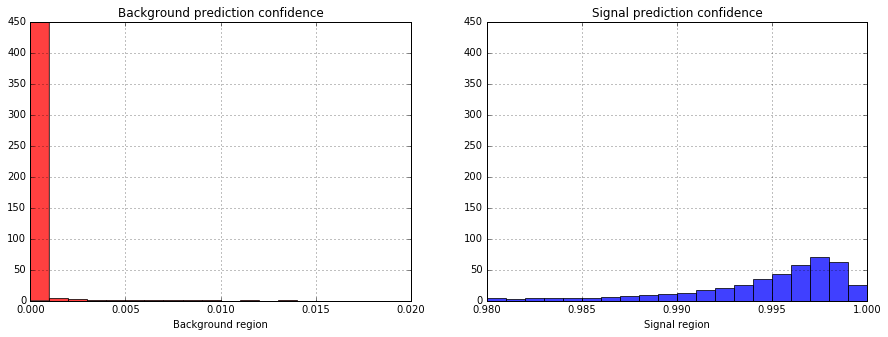

In [4]:
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# Plot histograms of neural network output:
fig.add_subplot(121)
n, bins, patches = plt.hist(y_pred, 1000, color='red', normed=1, alpha=0.75)
plt.xlim(0,.02)
plt.grid(True)
plt.xlabel('Background region')
plt.title('Background prediction confidence')

fig.add_subplot(122)
n, bins, patches = plt.hist(y_pred, 1000, color='blue', normed=1, alpha=0.75)
plt.xlim(.98,1)
plt.grid(True)
plt.xlabel('Signal region')
plt.title('Signal prediction confidence')
plt.show()

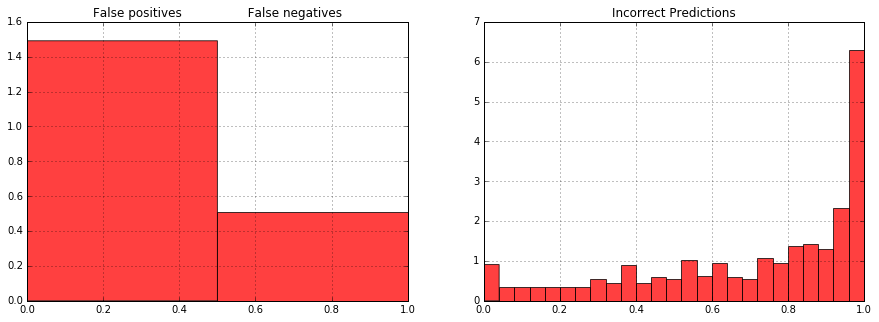

In [5]:
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# Collect incorrect predictions
trueidx = np.where(np.equal(np.round(y_pred),y_) == True)[0]
wrongidx = np.where(np.equal(np.round(y_pred),y_) != True)[0]
    
fig.add_subplot(121)
n, bins, patches = plt.hist(y_[wrongidx], 2, color='red', normed=1, alpha=0.75)
plt.xlim(0,1)
plt.grid(True)
plt.title('False positives                 False negatives')

fig.add_subplot(122)
n, bins, patches = plt.hist(y_pred[wrongidx], 25, color='red', normed=1, alpha=0.75)
plt.xlim(0,1)
plt.grid(True)
plt.title('Incorrect Predictions')
plt.show()

In [6]:
print('Actual percent signal:                    ' + str((y_     == 1).sum()/float(len(y_))))
print('Predicted percent signal:                 ' + str((y_pred > .5).sum()/float(len(y_pred))))
print('Absolute number of incorrect predictions: ' + str(len(wrongidx)))

Actual percent signal:                    0.502071185457
Predicted percent signal:                 0.5102767737
Absolute number of incorrect predictions: 633


In [7]:
allEh   = []
wrongEh = []
xvrsh = np.reshape(xv,(len(xv),30,400))
for event in range(len(xvrsh)):
    nzeros = 30
    for sli in xvrsh[event]: 
        if max(sli) == 0: nzeros -=1
    allEh.append(nzeros)
for event in wrongidx:
    nzeros = 30
    for sli in xvrsh[event]: 
        if max(sli) == 0: nzeros -=1
    wrongEh.append(nzeros)

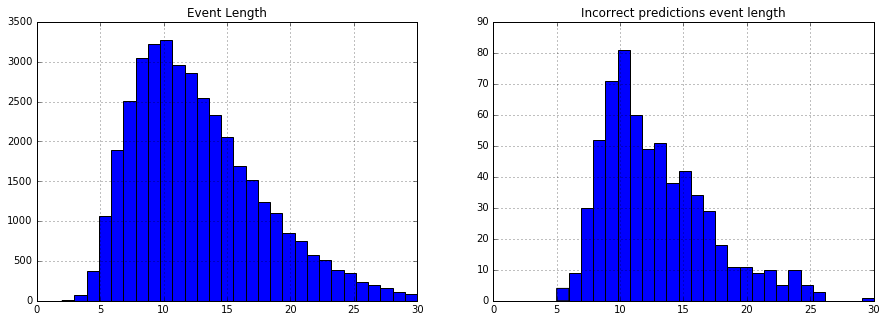

In [8]:
fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)
fig.add_subplot(121)
plt.hist(allEh,29)
plt.xlim(0,30)
plt.grid(True)
plt.title('Event Length')

fig.add_subplot(122)
plt.hist(wrongEh,26)
plt.xlim(0,30)
plt.grid(True)
plt.title('Incorrect predictions event length')
plt.show()

(37901,)


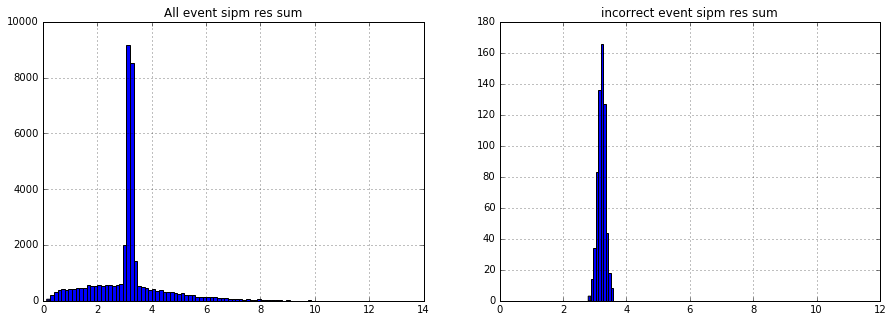

In [9]:
res_sums = np.zeros(len(xv),dtype=np.float32)
wr_res_sums  = np.zeros(len(wrongidx),dtype=np.float32)
xv = np.reshape(xv,(len(xv),30,400))
print(np.sum(np.sum(xv, axis=1),axis=1).shape)

fig = plt.figure();
fig.set_figheight(5.0)
fig.set_figwidth(15.0)
fig.add_subplot(121)
plt.hist(np.sum(np.sum(xv, axis=1),axis=1),100)
plt.grid(True)
plt.title('All event sipm res sum')

fig.add_subplot(122)
plt.hist(np.sum(np.sum(xv, axis=1),axis=1)[wrongidx],10)
plt.grid(True)
plt.xlim(0,12)
plt.title('incorrect event sipm res sum')
plt.show()

In [10]:
sg=h5py.File('in_data/dnn_MAGBOX_oldPhys_600k_si_v2x2x2_r200x200x200.h5', 'r')
bg=h5py.File('in_data/dnn_MAGBOX_oldPhys_600k_bg_v2x2x2_r200x200x200.h5', 'r')

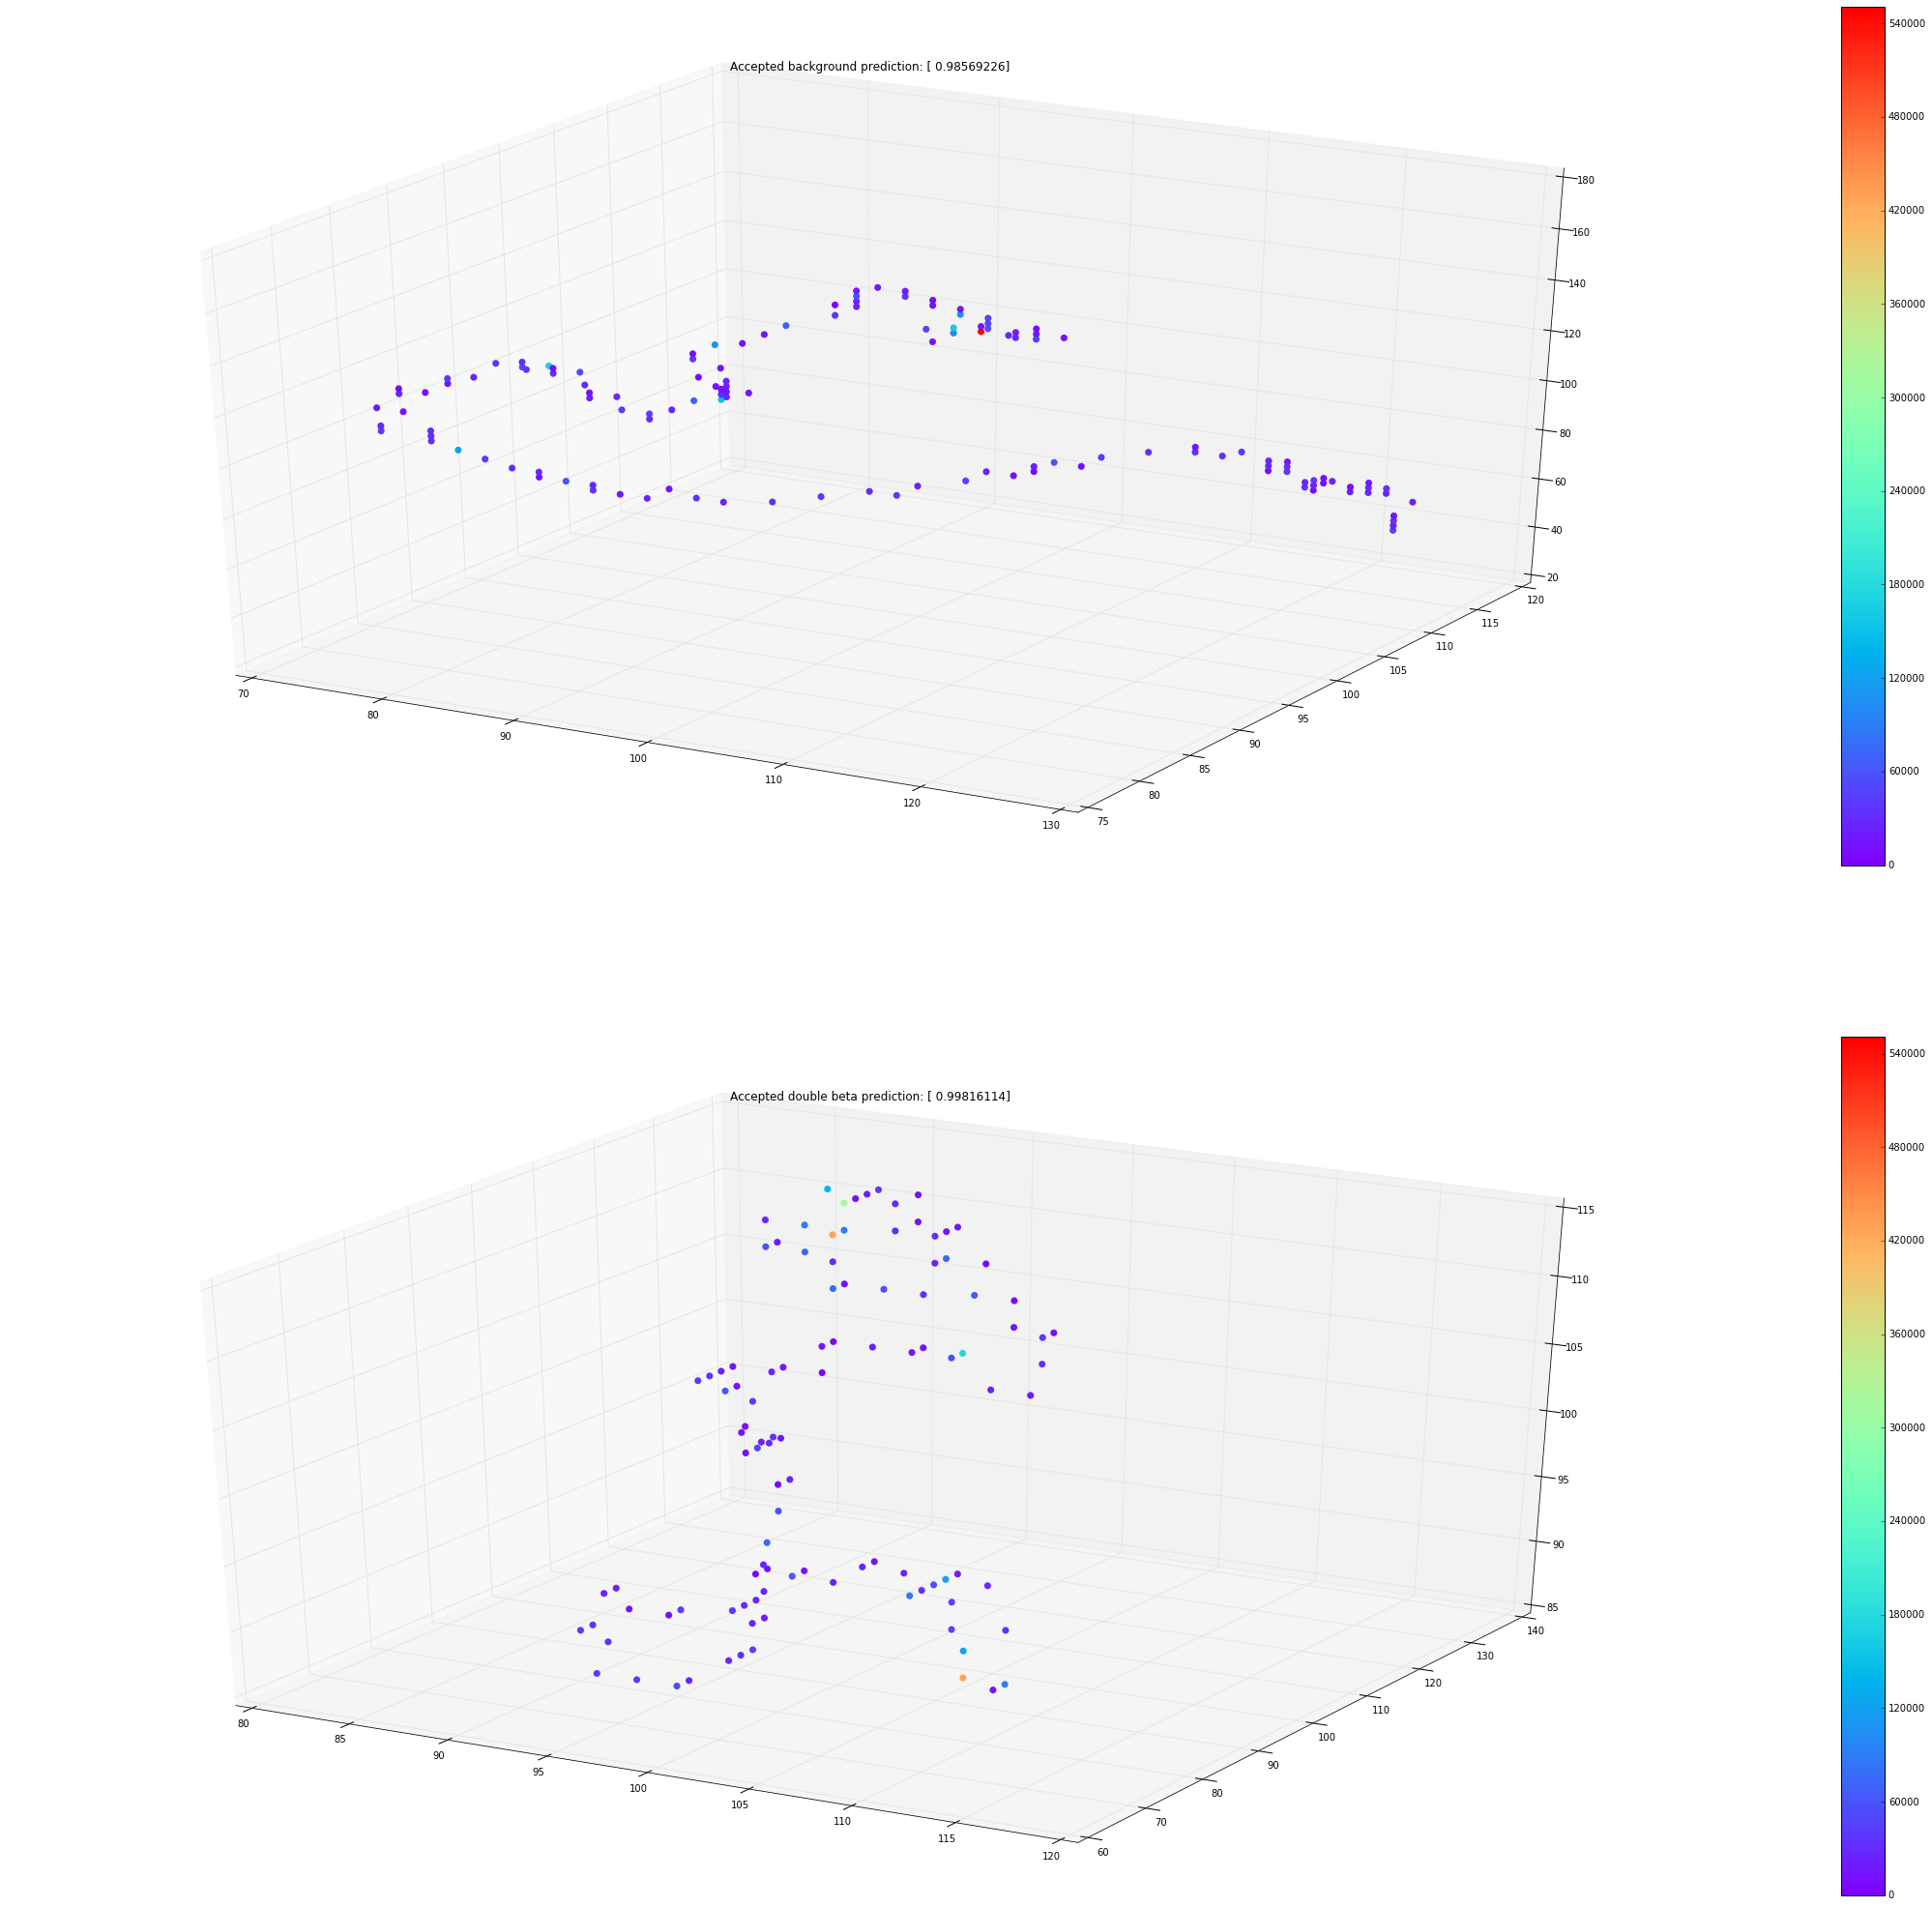

In [11]:
fig = plt.figure()
fig.set_figheight(35.0)
fig.set_figwidth(40.0)
fpos = [wrongidx[i]for i in np.where(y_[wrongidx]==0)[0]]
#print(y_[fpos],y_pred[fpos]) # sanity check
r = rd.sample(fpos,1)[0]
ax = fig.add_subplot(211, projection='3d')
fpev = np.array(bg['trk{0}'.format((r+Ntrain-1)/2)])*2
emax = np.max(fpev[3]/1.e-3)
s1=ax.scatter(fpev[0],fpev[1],fpev[2],c=fpev[3]/1.e-3,cmap=plt.get_cmap('rainbow'),vmin=0,vmax=emax,s=50,edgecolors='None')
s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
ax.set_title('Accepted background prediction: '+ str(y_pred[r]))
cb1 = plt.colorbar(s1);

tpos = [trueidx[i]for i in np.where(y_[trueidx]==1)[0]]
ax = fig.add_subplot(212, projection='3d')
r = rd.sample(tpos,1)[0]
true = np.array(sg['trk{0}'.format((r+Ntrain)/2)])*2
s2=ax.scatter(true[0],true[1],true[2],c=true[3]/1.e-3,cmap=plt.get_cmap('rainbow'),vmin=0,vmax=emax,s=50,edgecolors='None')
s2.set_edgecolors = s2.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
ax.set_title('Accepted double beta prediction: ' + str(y_pred[r]))
cb2 = plt.colorbar(s2);
plt.show()

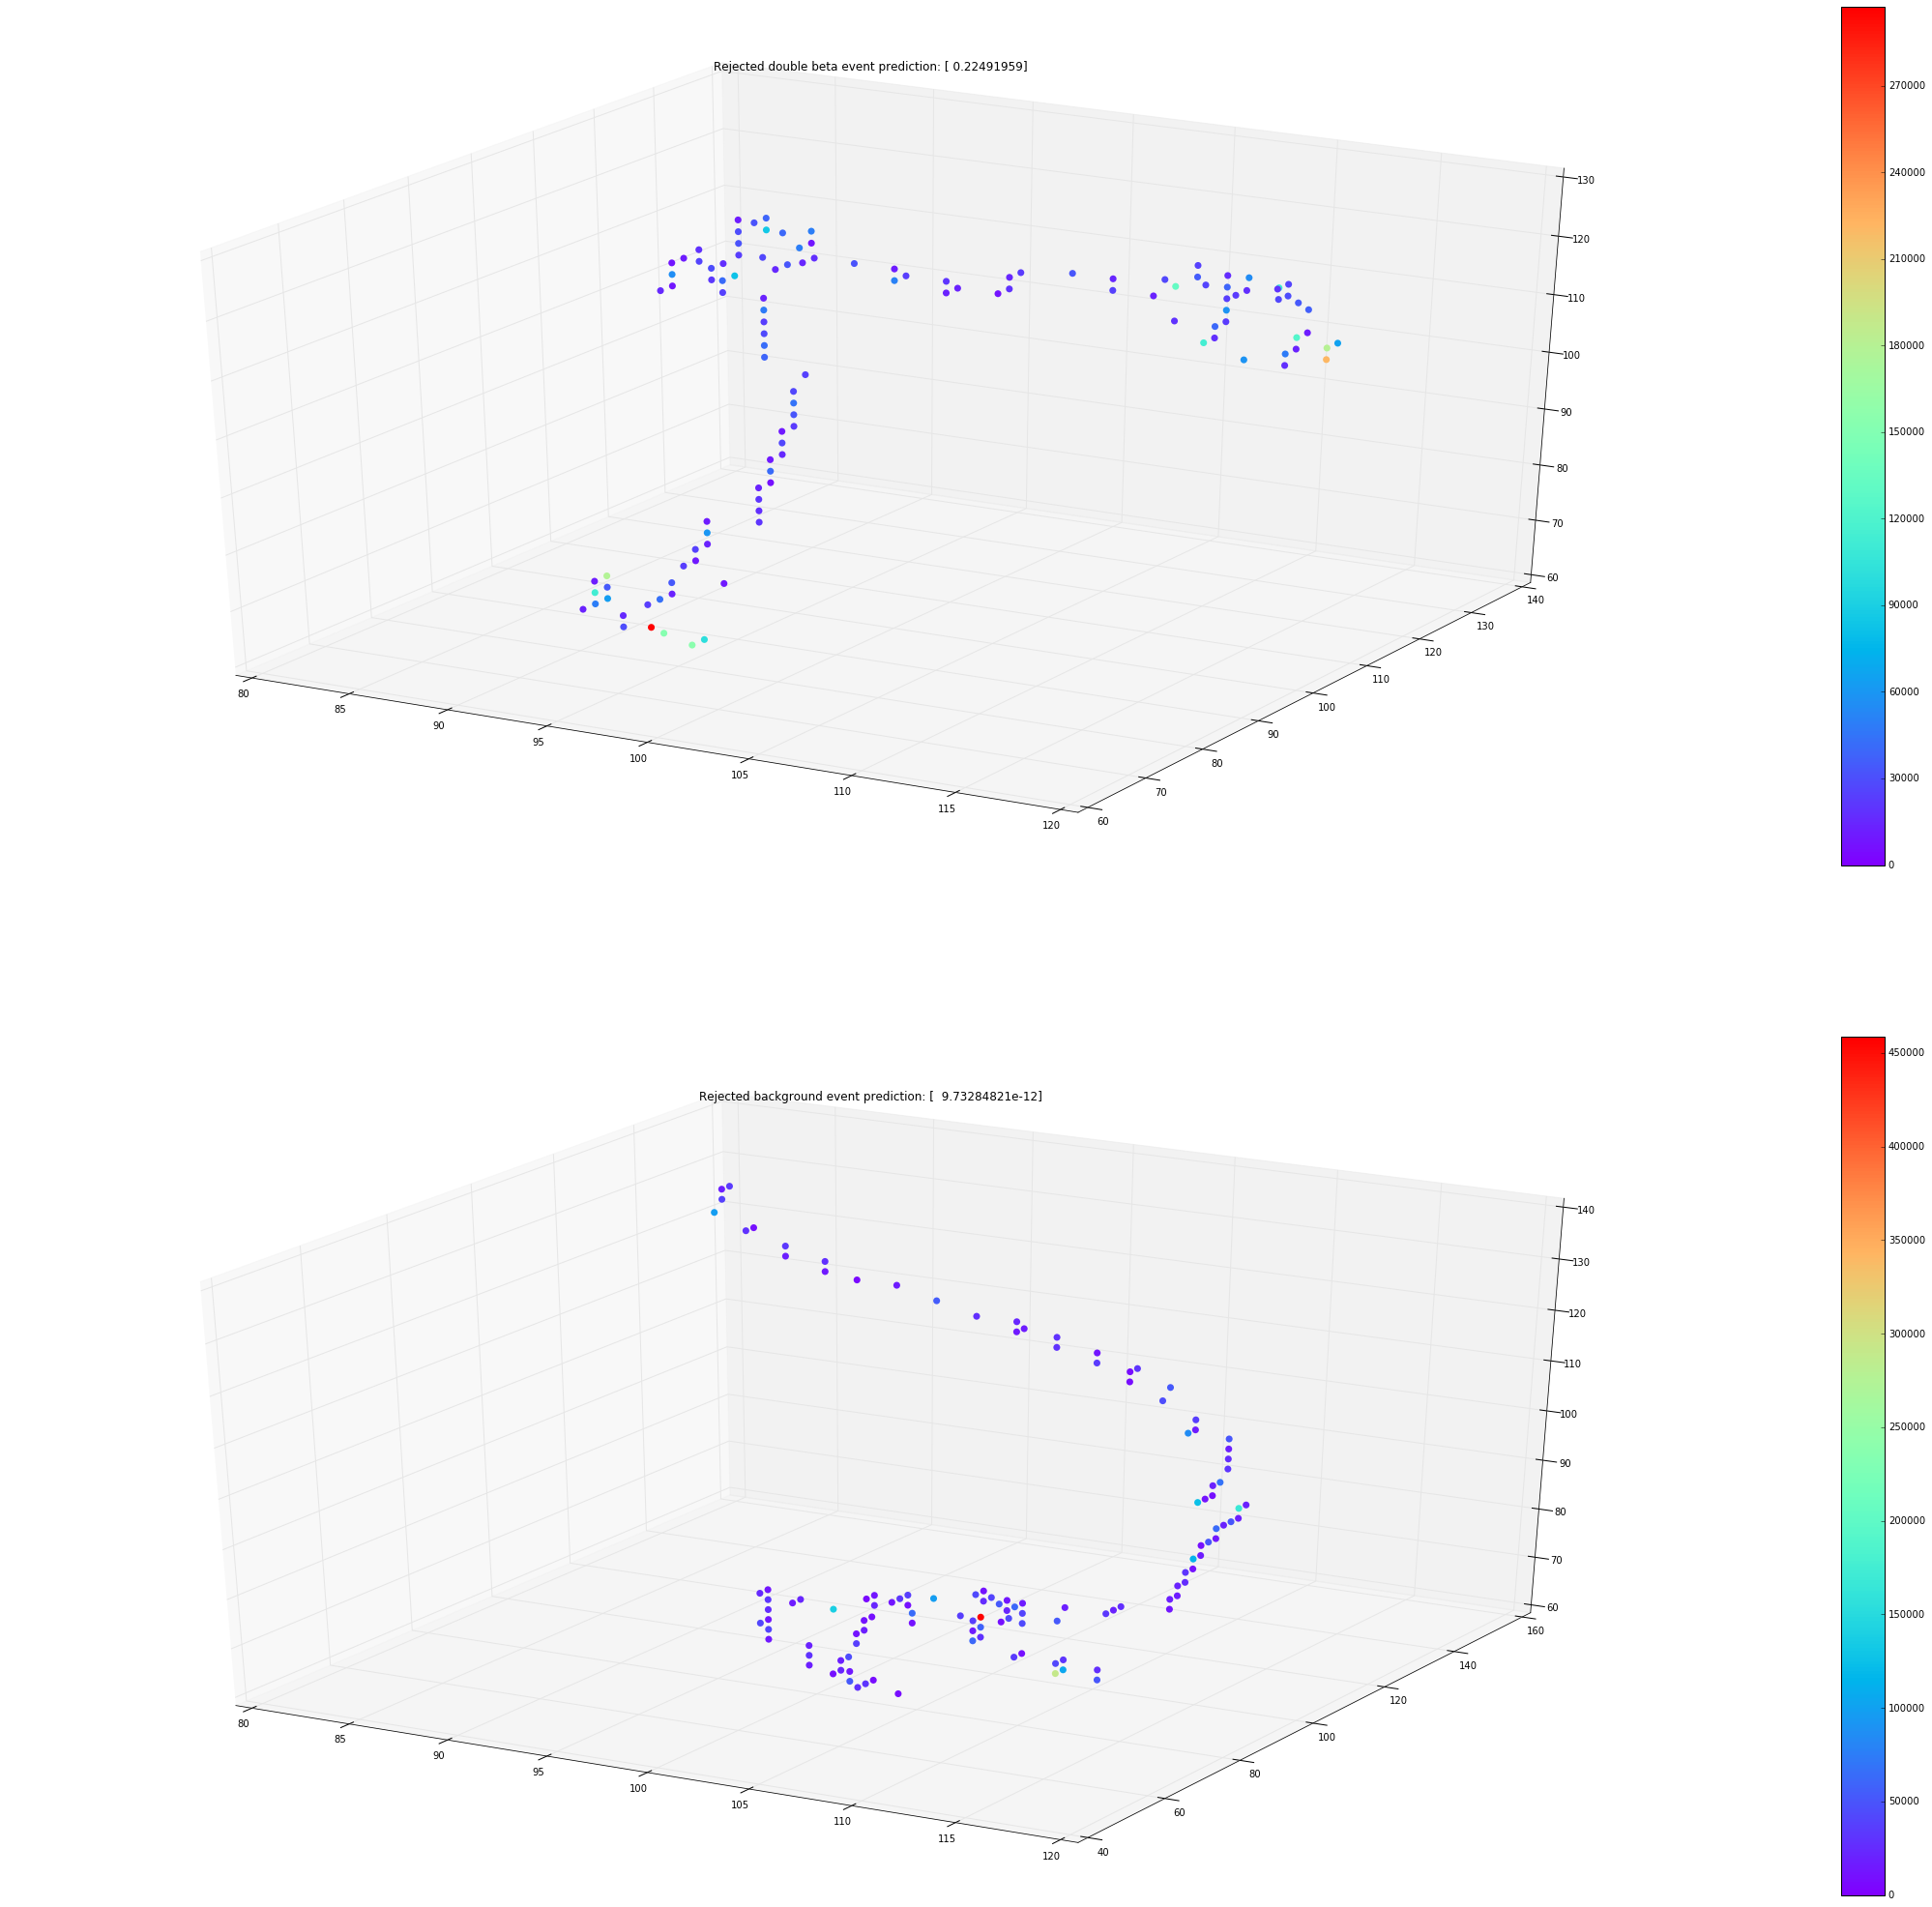

In [12]:
fig = plt.figure()
fig.set_figheight(35.0)
fig.set_figwidth(40.0)
misdb = [wrongidx[i] for i in np.where(y_[wrongidx]==1)[0]]
r = rd.sample(misdb,1)[0]
ax = fig.add_subplot(211, projection='3d')
mdb = np.array(sg['trk{0}'.format((r+Ntrain-1)/2)])*2
emax = np.max(mdb[3]/1.e-3)
s1=ax.scatter(mdb[0],mdb[1],mdb[2],c=mdb[3]/1.e-3,cmap=plt.get_cmap('rainbow'),vmin=0,vmax=emax,s=50,edgecolors='None')
s1.set_edgecolors = s1.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera
ax.set_title('Rejected double beta event prediction: ' + str(y_pred[r]))
cb1 = plt.colorbar(s1);

tneg = [trueidx[i]for i in np.where(y_[trueidx]==0)[0]]
ax = fig.add_subplot(212, projection='3d')
r = rd.sample(tneg,1)[0]
tbg = np.array(bg['trk{0}'.format((r+Ntrain)/2)])*2
emax = np.max(tbg[3]/1.e-3)
s2=ax.scatter(tbg[0],tbg[1],tbg[2],c=tbg[3]/1.e-3,cmap=plt.get_cmap('rainbow'),vmin=0,vmax=emax,s=50,edgecolors='None')
s2.set_edgecolors = s2.set_facecolors = lambda *args:None;  # this disables automatic setting of alpha relative of distance to camera

ax.set_title('Rejected background event prediction: ' + str(y_pred[r]))
cb2 = plt.colorbar(s2);
plt.show()
sg.close()
bg.close()

In [13]:
def compute_efficiency(threshold, predictions, labels):
    total_signal_events = float((labels == 1).sum())
    idxs     = np.where(labels == 1)[0]
    pred_sg  = (predictions[idxs] >= threshold).sum()
    return pred_sg/total_signal_events

def compute_background_rejection(threshold,predictions,labels):
    total_background_events = float((labels == 0).sum())
    idxs     = np.where(labels == 0)[0]
    pred_bg  = (predictions[idxs] <= threshold).sum()
    return pred_bg/total_background_events

In [14]:
length = 50001
efficiency           = np.zeros((length,),dtype=np.float32)
background_rejection = np.zeros((length,),dtype=np.float32)

fom       = 0
fom_thres =-1
THR = np.array(range(length), dtype=np.float32)/length
for i,t in enumerate(THR): 
    s = compute_efficiency(t,y_pred,y_)
    b = compute_background_rejection(t,y_pred,y_)
    efficiency[i]           = s
    background_rejection[i] = b
    fom_temp = s/(np.sqrt(1-b))
    if fom_temp > fom and b != 1.0: 
        fom = fom_temp
        fom_thres = t

Example Threshold:      0.92
FOM:                    8.90069972591
Efficiency:             0.950023648116
Background Acceptance:  0.0113925392115
----------------------------------------
Max FOM Threshold:      0.99364
Max FOM:                13.3218317361
Max FOM Efficiency:     0.605601975931
Max FOM Bg Acceptance:  0.00206655362442


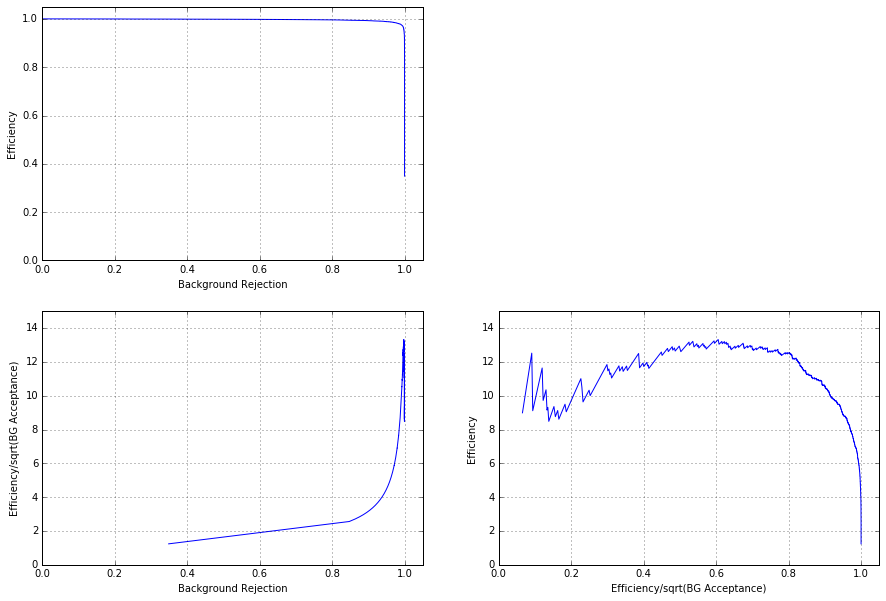

In [15]:
test_thr =.92
print('Example Threshold:      ' + str(test_thr))
print('FOM:                    ' + str(compute_efficiency(test_thr,y_pred,y_)/np.sqrt((1-compute_background_rejection(test_thr,y_pred,y_)))))
print('Efficiency:             ' + str(compute_efficiency(test_thr,y_pred,y_)))
print('Background Acceptance:  ' + str(1 - compute_background_rejection(test_thr,y_pred,y_)))
print('----------------------------------------')
print('Max FOM Threshold:      ' + str(fom_thres))
print('Max FOM:                ' + str(fom))
print('Max FOM Efficiency:     ' + str(compute_efficiency(fom_thres,y_pred,y_)))
print('Max FOM Bg Acceptance:  ' + str(1-compute_background_rejection(fom_thres,y_pred,y_)))

fig = plt.figure()
fig.set_figheight(10.0)
fig.set_figwidth(15.0)
fig.add_subplot(221)
plt.plot(efficiency,background_rejection)
plt.xlabel('Background Rejection')
plt.ylabel('Efficiency')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.grid(True)

fig.add_subplot(223)
plt.plot(background_rejection, efficiency/np.sqrt(1-background_rejection))
plt.xlim([.0,1.05])
plt.ylim([0,15])
plt.xlabel('Background Rejection')
plt.ylabel('Efficiency/sqrt(BG Acceptance)')
plt.grid(True)

fig.add_subplot(224)
plt.plot(efficiency,efficiency/np.sqrt(1-background_rejection))
plt.xlim([.0,1.05])
plt.ylim([0,15])
plt.ylabel('Efficiency/sqrt(BG Acceptance)')
plt.xlabel('Efficiency')
plt.grid(True)
plt.show()